# Time Series Data Forecasting

### **Importing Important Libraries**

In [1]:
import os
import warnings 
import pprint
from typing import Dict

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import sys 

sys.path.append('../')

### **Prepration of Environment**

In [2]:
def path_to_work(end_directory: str = 'notebooks') -> None:
   
    curr_dir = os.path.dirname(os.path.realpath("__file__"))

    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return f'Changed directory to: {curr_dir}'
    else:
        return f'Current working directory: {curr_dir}'



In [3]:
def plot_box_plot(df: pd.core.frame.DataFrame, dataset_name: str, xlim=None) -> None:
    if xlim is not None:
        plt.xlim(*xlim)

    plt.title(f"Horizontal Boxplot {dataset_name}")
    plt.ylabel('Dependent Variables')
    plt.xlabel('Measurement x')
    ax = sns.boxplot(data=df, orient='h', palette='Set2', notch=False)
    plt.show()

In [4]:
def save_image(img: 'matplotlib', name: str, path: str = 'reports/images/') -> None:
    img.get_figure().savefig(f"{path}/{name}.png")
    print(f"{name} saved at {path}.")


In [5]:
def save_dataframe(df: pd.core.frame.DataFrame, path: str = 'data/cleansing/') -> None:
    df.to_csv(path_or_buf=path, sep=',', index=False, encoding='utf8')
    print(f"Saved data at {path}")


In [6]:
def test_stationary(timeseries: pd.core.series.Series) -> None:
    
    # Calculate rolling statistics
    rolmean = timeseries.rolling(window=30, center=False).mean()
    rolstd = timeseries.rolling(window=30, center=False).std()

    # Plot rolling statistics
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    df_test = adfuller(timeseries, autolag=None)
    df_output = pd.Series(
        df_test[0:4],
        index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'],
    )
    for k, v in df_test[4].items():
        df_output[f'Critical Value ({k})'] = v

    print(df_output)

In [7]:
def show_result_model(df_test: pd.core.frame.DataFrame, y_forecast, model_name: str, dict_results: Dict) -> pd.core.frame.DataFrame:

    future_forecast = pd.DataFrame(y_forecast, index=df_test.index, columns=['forecast'])
    mape = mean_absolute_percentage_error(df_test, y_forecast) * 100
    mse = mean_squared_error(df_test, y_forecast, squared=True)
    dict_results[model_name] = [mape, mse]

    pd.concat([df_test, future_forecast], axis=1).plot()

    plt.legend()
    plt.grid(True)
    plt.xlabel("Time (days)", fontsize=20)
    plt.ylabel("Price (R$)", fontsize=20)
    plt.title(f'MAPE = {mape:.2f} % | MSE = {mse:.2f}', fontsize=25)

    return future_forecast

### **Working Path**

In [8]:
path_to_work('notebooks')

'Changed directory to: /Users/shubham/Documents/Projects/Time Series Data Forecasting - StockMarket/notebooks'

### **Set Config**

In [9]:
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Seaborn rcParams
# ----------
rc={'savefig.dpi': 500,
    'figure.autolayout': True,
    'figure.figsize': [17, 12],
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'font.size': 10,
    'lines.linewidth': 1.0,
    'lines.markersize': 8,
    'legend.fontsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15}

sns.set(context='notebook',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True,
        rc=rc)

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

In [10]:
# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set(style='darkgrid', palette='deep')

---

## **1. Loading The DataSets**

In [11]:
%%time

df_vale3 = pd.read_csv('/Users/shubham/Documents/Projects/Time Series Data Forecasting - StockMarket/Data/vale3_2010-2020.csv', 
                                                                                    encoding='utf8', delimiter=',', verbose=True)

Tokenization took: 0.33 ms
Type conversion took: 0.91 ms
Parser memory cleanup took: 0.00 ms
CPU times: user 2.71 ms, sys: 1.29 ms, total: 4 ms
Wall time: 4.02 ms


In [12]:
df_vale3.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jun 19, 2020",55.17,56.33,56.60,54.71,37.86M,-1.78%
1,"Jun 18, 2020",56.17,56.30,56.54,55.61,25.69M,-0.05%
2,"Jun 17, 2020",56.20,55.49,56.44,55.15,27.57M,1.46%
3,"Jun 16, 2020",55.39,55.49,55.50,54.22,29.17M,2.80%
4,"Jun 15, 2020",53.88,52.50,54.43,52.13,27.32M,0.90%


Describing The Data

In [13]:
df_vale3.info()
print("\nDataframe:\n{} rows\n{} columns".format(df_vale3.shape[0], df_vale3.shape[1]))

list_columns = (df_vale3.columns).tolist()
print("-"*25, "List Columns", "-"*25, end='\n')
print(list_columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2495 non-null   object 
 1   Price     2495 non-null   float64
 2   Open      2495 non-null   float64
 3   High      2495 non-null   float64
 4   Low       2495 non-null   float64
 5   Vol.      2495 non-null   object 
 6   Change %  2495 non-null   object 
dtypes: float64(4), object(3)
memory usage: 136.6+ KB

Dataframe:
2495 rows
7 columns
------------------------- List Columns -------------------------
['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']


**NOTES**

1. Columns:

- Date (x-axis): date of the data
- Price (y-axis): closing price. What will be predicted
- Open: opening price
- High: maximum price reached
- Low: minimum price reached
- Vol.: volume of traded shares
- Change %: percentage change compared to the previous day

---

## **2. Data Exploration**

In [14]:
df_vale3.nunique()

Date        2495
Price       1845
Open        1816
High        1852
Low         1845
Vol.        1339
Change %     927
dtype: int64

In [15]:
df_vale3.mode(dropna=False, numeric_only=True)

,Price,Open,High,Low
0,27.43,51.00,38.15,17.65
1,NaN,NaN,44.33,NaN
2,NaN,NaN,52.09,NaN
3,NaN,NaN,53.12,NaN


In [16]:
df_vale3.isnull().sum().sum()

0

In [17]:
df_vale3.duplicated().any()

False

---

## **3. Data Preparation: Cleaning**
The analysis of the time series is univariate, meaning only the price column over time will be predicted. This ensures a better comparison among statistical models, machine learning, and deep learning approaches.

**Column Prepration**

In [18]:
df_vale3.columns =  map(str.lower, df_vale3.columns)
print(df_vale3.columns)

list_columns = df_vale3.columns
print(list_columns)

Index(['date', 'price', 'open', 'high', 'low', 'vol.', 'change %'], dtype='object')
Index(['date', 'price', 'open', 'high', 'low', 'vol.', 'change %'], dtype='object')


#### **Data**
- Transform the date format from (Jun 19, 2020) to (2020-06-19).
- Convert the data type of the `date` column to `datetime64`.

In [19]:
df_vale3['date'] = pd.to_datetime(df_vale3['date'])
df_vale3 = df_vale3.iloc[::-1]
df_vale3.head(10)

,date,price,open,high,low,vol.,change %
2494,2010-05-20,39.79,40.21,40.93,39.79,6.09M,-3.61%
2493,2010-05-21,42.46,40.17,42.75,39.92,3.86M,6.71%
2492,2010-05-24,42.02,42.28,43.10,42.02,2.64M,-1.04%
2491,2010-05-25,42.39,40.86,42.67,40.23,4.53M,0.88%
2490,2010-05-26,42.17,42.96,44.52,42.17,5.53M,-0.52%
2489,2010-05-27,44.82,43.73,45.03,43.59,5.07M,6.28%
2488,2010-05-28,44.42,44.82,45.39,43.97,4.42M,-0.89%
2487,2010-05-31,45.37,44.73,45.50,44.73,4.78M,2.14%
2486,2010-06-01,44.39,44.30,45.09,44.28,3.37M,-2.16%
2485,2010-06-02,45.32,44.28,45.73,44.28,2.04M,2.10%


In [20]:
df_vale3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 2494 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2495 non-null   datetime64[ns]
 1   price     2495 non-null   float64       
 2   open      2495 non-null   float64       
 3   high      2495 non-null   float64       
 4   low       2495 non-null   float64       
 5   vol.      2495 non-null   object        
 6   change %  2495 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 136.6+ KB


Add Index

In [21]:
df_vale3_date_index = df_vale3
df_vale3_date_index.index.names = ['date']
df_vale3_date_index.index = df_vale3['date']
df_vale3_date_index.index = pd.to_datetime(df_vale3.index)

print(df_vale3_date_index.index.freq)
print(df_vale3_date_index.index)

None
DatetimeIndex(['2010-05-20', '2010-05-21', '2010-05-24', '2010-05-25',
               '2010-05-26', '2010-05-27', '2010-05-28', '2010-05-31',
               '2010-06-01', '2010-06-02',
               ...
               '2020-06-05', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-12', '2020-06-15', '2020-06-16', '2020-06-17',
               '2020-06-18', '2020-06-19'],
              dtype='datetime64[ns]', name='date', length=2495, freq=None)


In [22]:
df_vale3_date_index.head()

,date,price,open,high,low,vol.,change %
date,,,,,,,
2010-05-20,2010-05-20,39.79,40.21,40.93,39.79,6.09M,-3.61%
2010-05-21,2010-05-21,42.46,40.17,42.75,39.92,3.86M,6.71%
2010-05-24,2010-05-24,42.02,42.28,43.10,42.02,2.64M,-1.04%
2010-05-25,2010-05-25,42.39,40.86,42.67,40.23,4.53M,0.88%
2010-05-26,2010-05-26,42.17,42.96,44.52,42.17,5.53M,-0.52%


### **Verify Data Quality**
- Check index
- Check for irrelevant values
- Check for outliers

#### Check Index

In [23]:
df_vale3.index

DatetimeIndex(['2010-05-20', '2010-05-21', '2010-05-24', '2010-05-25',
               '2010-05-26', '2010-05-27', '2010-05-28', '2010-05-31',
               '2010-06-01', '2010-06-02',
               ...
               '2020-06-05', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-12', '2020-06-15', '2020-06-16', '2020-06-17',
               '2020-06-18', '2020-06-19'],
              dtype='datetime64[ns]', name='date', length=2495, freq=None)

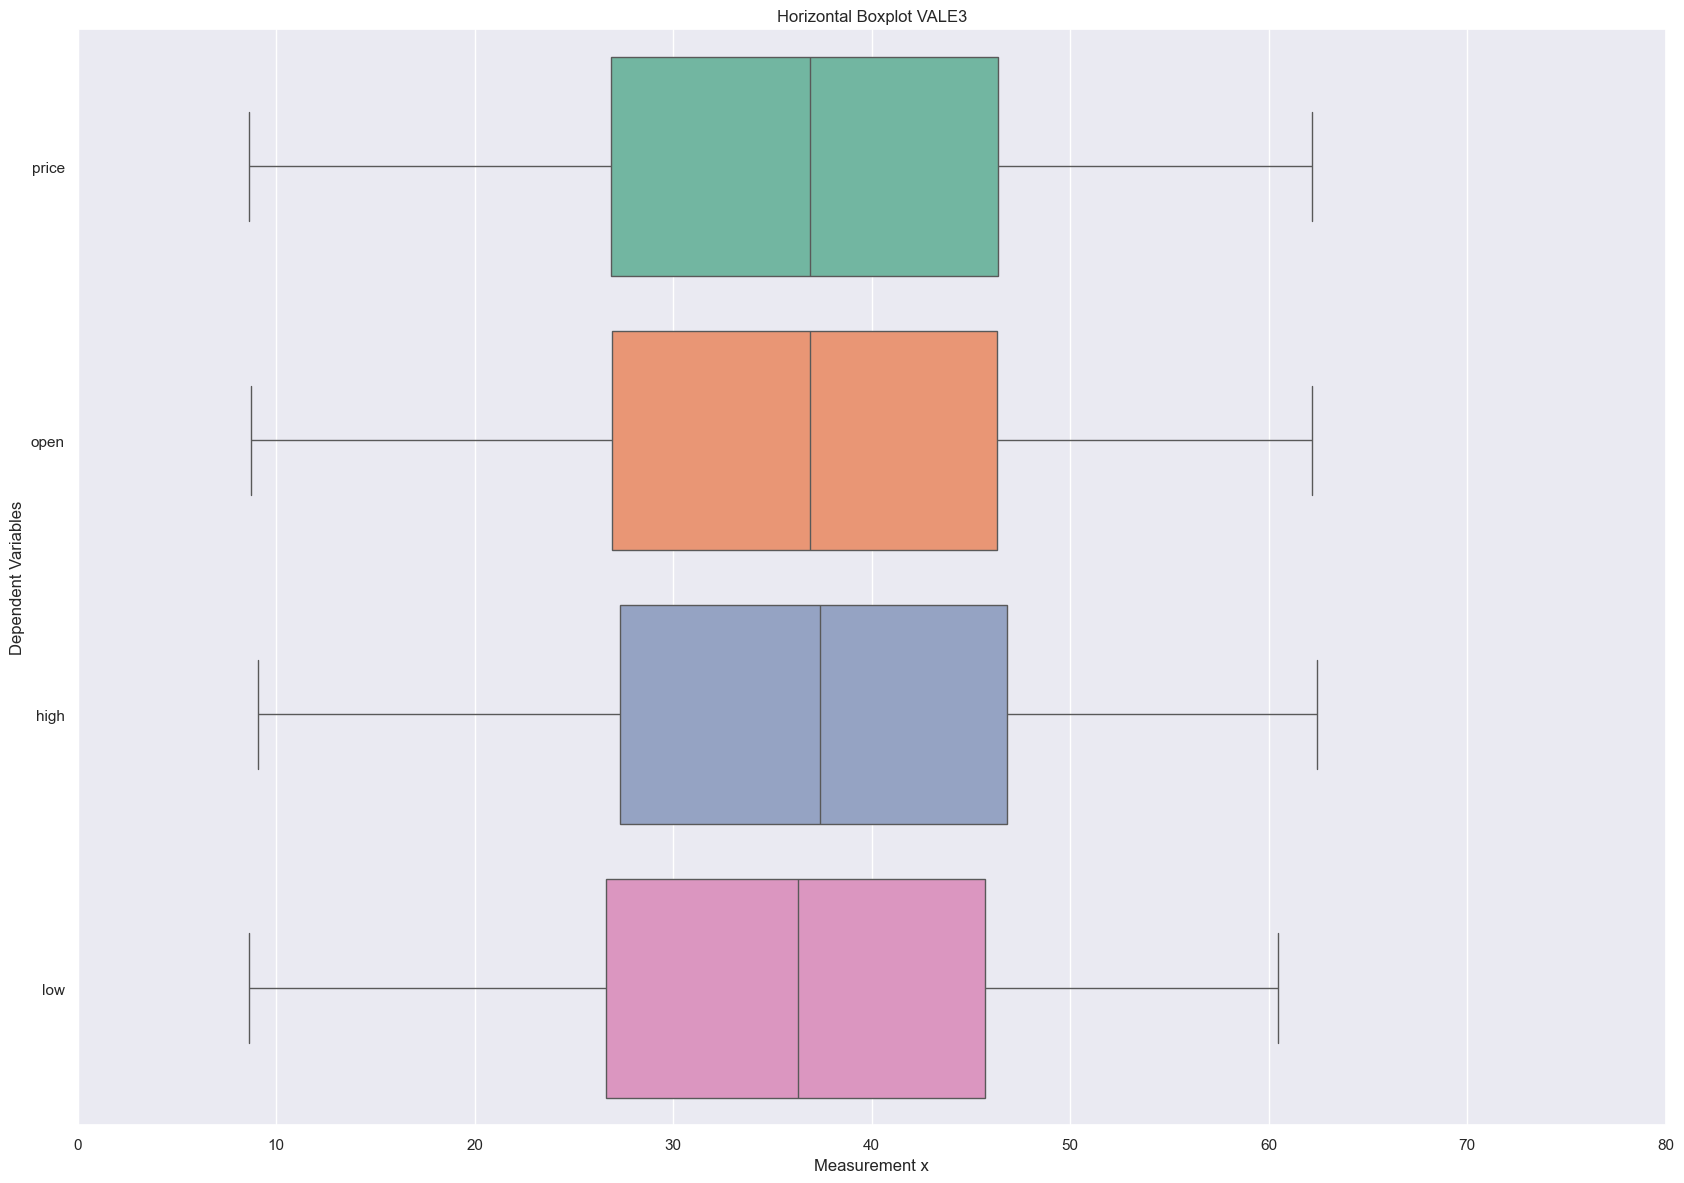

In [24]:
plot_box_plot(df_vale3, 'VALE3', (0, 80))

---

## **4. Data Understanding: Statistics and Plot**
### **Data Explorate**
- Analysis of Time Series Components
- Distribution
- Seasonality
- Trend
- Noise

#### Distribution

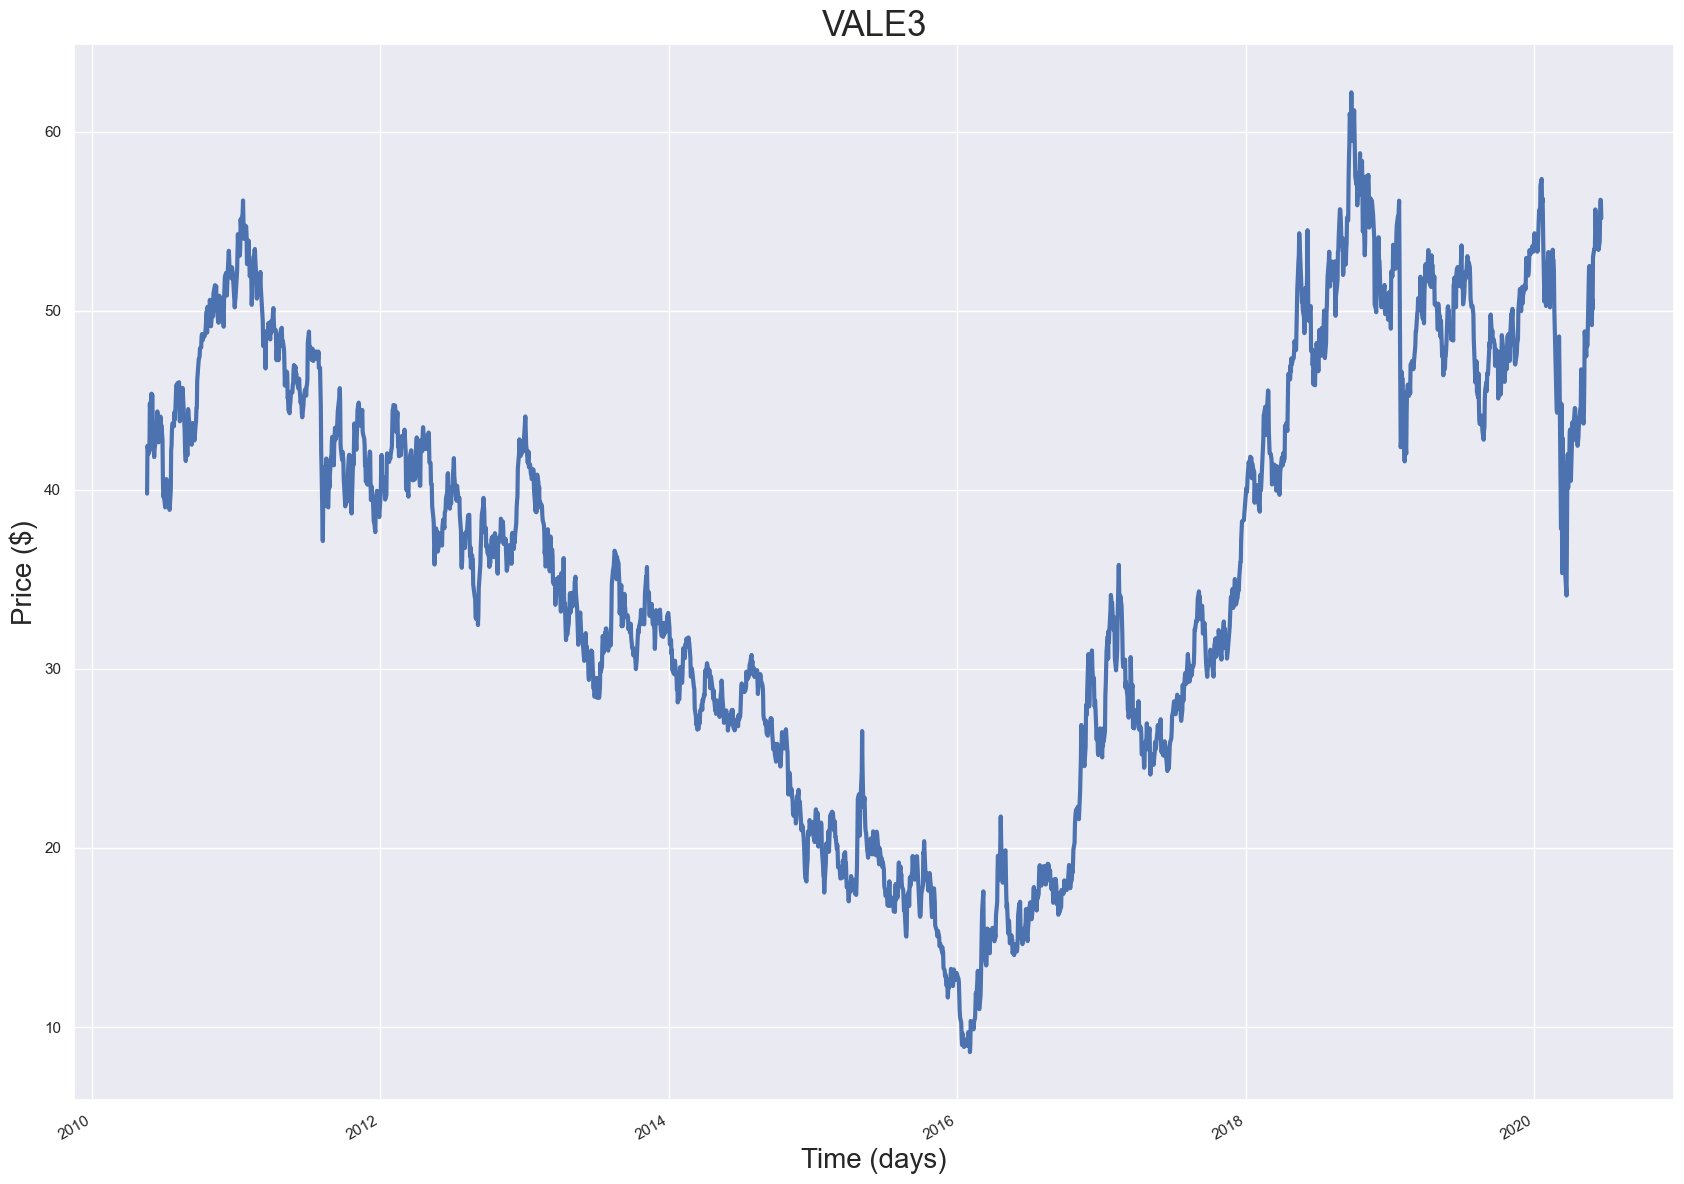

In [25]:
img_vale3_distr_line = df_vale3_date_index['price'].plot(linewidth=3)

plt.title(f'VALE3', fontsize=25)
plt.xlabel("Time (days)", fontsize=20)
plt.ylabel("Price ($)", fontsize=20)
plt.grid(True)

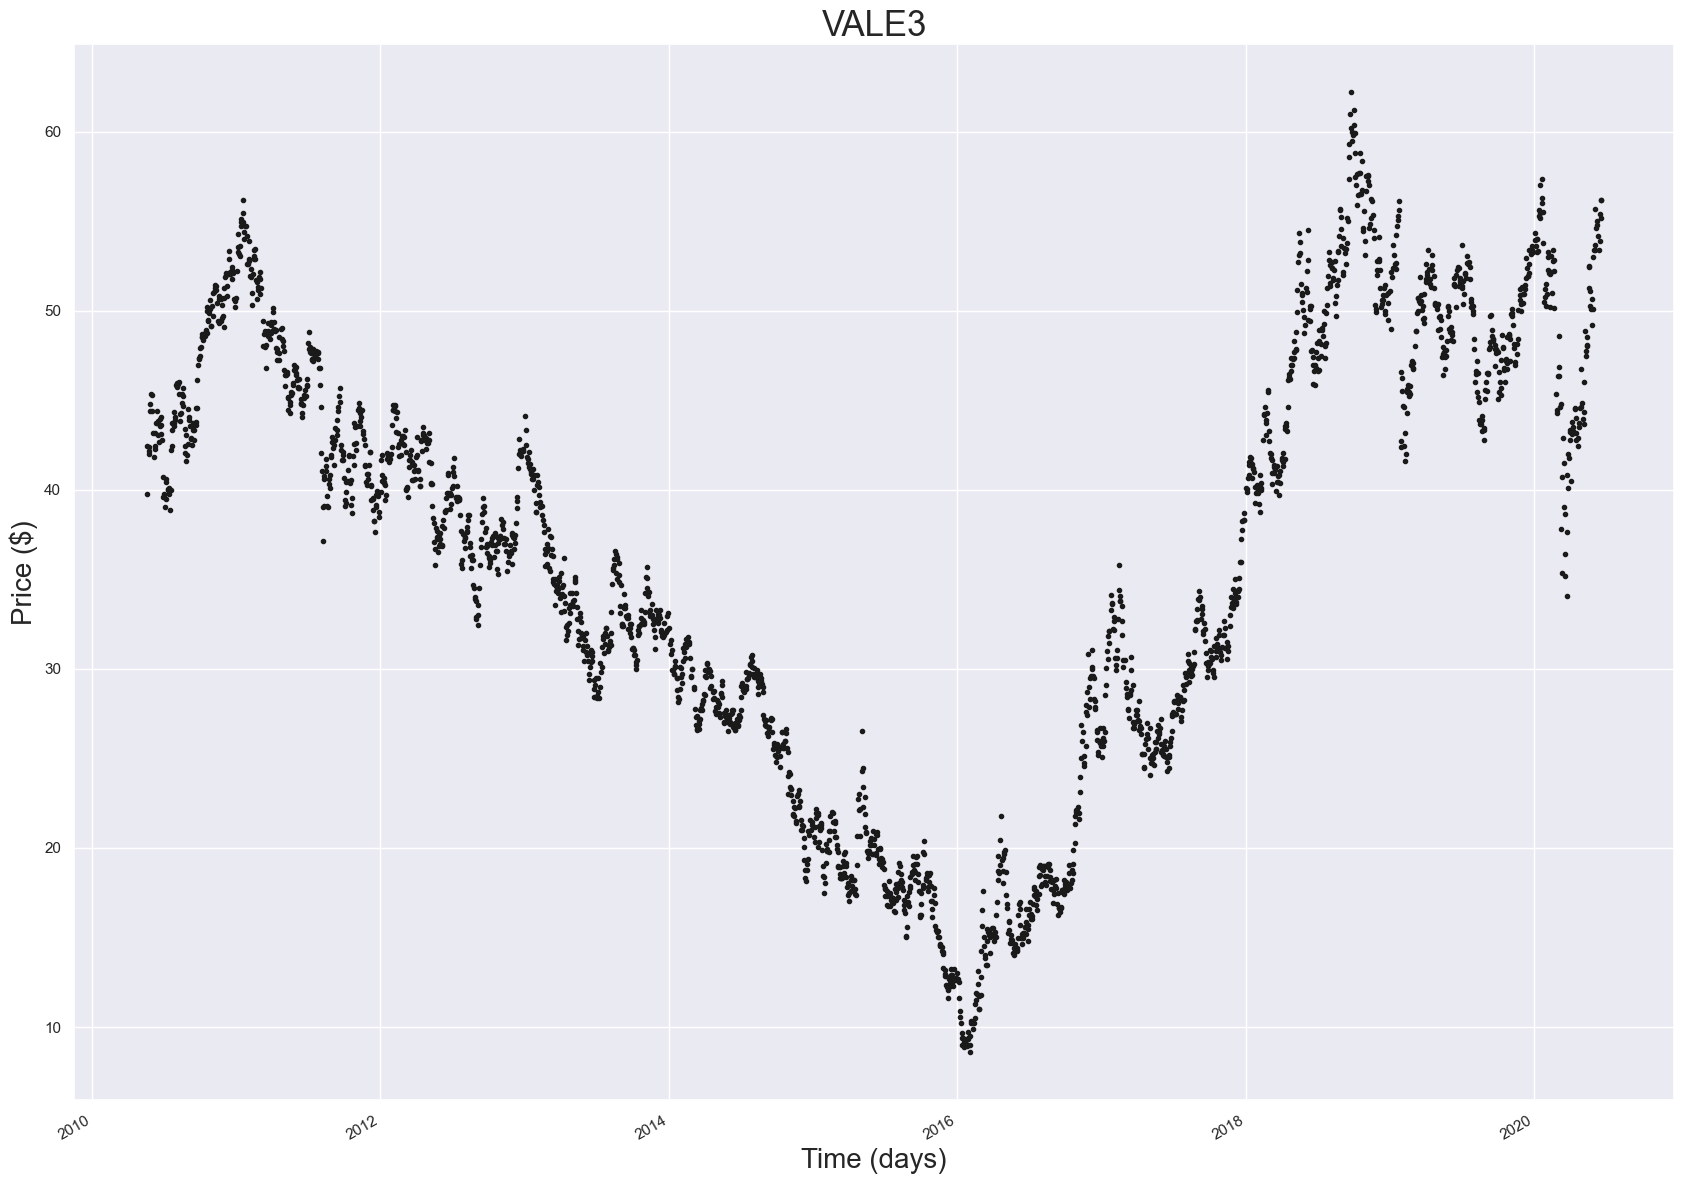

In [31]:
img_vale3_distr_scatter = df_vale3_date_index['price'].plot(style='k.')

plt.title(f'VALE3', fontsize=25)
plt.xlabel("Time (days)", fontsize=20)
plt.ylabel("Price ($)", fontsize=20)
plt.grid(True)